In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
constants = {
    'nu': 1,
    'tau': 1,
    'tau_s': 1,
    'spike_hidden': 1,
    'spike_out': 1
}

In [3]:
def eta(s):
    # s -- time
    return -constants['nu'] * np.exp(-s/constants['tau']) * np.heaviside(s, 0)

def eps(s, d):
    # s -- time, d -- connection delay
    return (s - d)/constants['tau_s']*np.exp(-(s - d)/constants['tau_s']) * np.heaviside(s - d, 0)

def u(t, last_t, d, w, previous_last_t):
    # t -- time, last_t -- last spike time, d -- connection delay, w -- weight of connection
    return eta(t - last_t) + np.sum(w * eps(np.transpose(t - previous_last_t - np.transpose(d)), d), axis=0)

In [4]:
class SRM:
    def __init__(self, input_size, hidden_size):
        self.sensors_level_size = 20
        self.hidden_level_size = hidden_size
        self.out_level_size = 2
        
        self.w1 = np.random.uniform(size=(self.sensors_level_size, self.hidden_level_size))
        self.w2 = np.random.uniform(size=(self.hidden_level_size, self.out_level_size))
        
        self.d1 = np.random.uniform(0, 7, size=(self.sensors_level_size, self.hidden_level_size))
        self.d2 = np.random.uniform(0, 7, size=(self.hidden_level_size, self.out_level_size))
                            
    def calculate_output(self, total_time, input_spikes):
        input_size = input_spikes.shape[0]
        self.last_t = np.zeros((input_size + self.hidden_level_size + self.out_level_size))
        self.spikes_hidden = np.zeros((self.hidden_level_size, total_time))
        self.spikes_out = np.zeros((self.out_level_size, total_time))
        u_hidden = np.zeros((self.hidden_level_size, total_time))
        u_out = np.zeros((self.out_level_size, total_time))
        for t in range(total_time):
            u_hidden[:, t] = u(t, self.last_t[input_size:-self.out_level_size], self.d1, self.w1, self.last_t[:input_size])
            u_out[:, t] = u(t, self.last_t[-self.out_level_size:], self.d2, self.w2, self.last_t[input_size:-self.out_level_size])
            self.spikes_hidden[:, t] = (u_hidden[:, t] >= constants['spike_hidden']).astype(int)
            self.spikes_out[:, t] = (u_out[:, t] >= constants['spike_out']).astype(int)
            # update last t
            self.last_t[:input_size] = np.maximum(self.last_t[:input_size], input_spikes[:, t]*t)
            self.last_t[input_size:-self.out_level_size] = np.maximum(self.last_t[input_size:-self.out_level_size], self.spikes_hidden[:, t]*t)
            self.last_t[-self.out_level_size:] = np.maximum(self.last_t[-self.out_level_size:], self.spikes_out[:, t]*t)
        return u_hidden, self.spikes_hidden, u_out, self.spikes_out

In [5]:
def generate_spikes(t, lam=1):
    spikes = np.zeros((t,))
    cur_time = 0
    while (cur_time < t):
        next_interval = int(-np.log(1. - np.random.rand()) / lam) + 1
        cur_time += next_interval
        if cur_time >= t:
            break
        spikes[cur_time] = 1
    return spikes

In [6]:
def generate_input_spikes(sensors_level_size, total_time):
    input_spikes = np.zeros((sensors_level_size, total_time))
    for i in range(sensors_level_size):
        input_spikes[i] = generate_spikes(100)
    return input_spikes

In [7]:
sensors_level_size = 20
time = 100
repeat = 5

In [8]:
spike_pattern1 = generate_input_spikes(sensors_level_size, time)
spike_pattern2 = generate_input_spikes(sensors_level_size, time)

In [9]:
spike_pattern1

array([[0., 1., 1., ..., 1., 0., 1.],
       [0., 1., 0., ..., 1., 1., 0.],
       [0., 0., 1., ..., 1., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [10]:
repeat_spike_pattern1 = np.repeat(spike_pattern1, repeat, axis=1)
repeat_spike_pattern1.shape

(20, 500)

In [11]:
spike_pattern2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 1., 1., 0.],
       [0., 0., 1., ..., 1., 1., 0.]])

In [12]:
repeat_spike_pattern2 = np.repeat(spike_pattern2, repeat, axis=1)
repeat_spike_pattern2.shape

(20, 500)

In [13]:
total_time=repeat*time

In [14]:
def plot_result(t, output1, output2, num, label1='1 pattern out', label2='2 pattern out'):
    fig = plt.figure(num, figsize=(14, 10))

    # Plot output1 as a function of time
    ax1 = fig.add_subplot(211)
    ax1.plot(t, output1[0])
    ax1.plot(t, output1[1])
    ax1.plot(t, len(t)*[constants['spike_out']], linestyle='dashed')
    ax1.set_xlabel('time')
    ax1.set_ylabel(label1)

    # Plot output2 as a function of time
    ax2 = fig.add_subplot(212)
    ax2.plot(t, output2[0])
    ax2.plot(t, output2[1])
    ax2.plot(t, len(t)*[constants['spike_out']], linestyle='dashed')
    ax2.set_xlabel('time')
    ax2.set_ylabel(label2)

In [15]:
def draw_plots(total_time, repeat_spike_pattern1, repeat_spike_pattern2, label1='1 pattern out', label2='2 pattern out'):
    SNN_10 = SRM(sensors_level_size, 10)
    SNN_20 = SRM(sensors_level_size, 20)
    SNN_50 = SRM(sensors_level_size, 50)
    _, _, u_out10_1, _ = SNN_10.calculate_output(total_time, repeat_spike_pattern1)
    _, _, u_out10_2, _ = SNN_10.calculate_output(total_time, repeat_spike_pattern2)
    _, _, u_out20_1, _ = SNN_20.calculate_output(total_time, repeat_spike_pattern1)
    _, _, u_out20_2, _ = SNN_20.calculate_output(total_time, repeat_spike_pattern2)
    _, _, u_out50_1, _ = SNN_50.calculate_output(total_time, repeat_spike_pattern1)
    _, _, u_out50_2, _ = SNN_50.calculate_output(total_time, repeat_spike_pattern2)
    plot_result(range(total_time), u_out10_1, u_out10_2, 1, label1, label2)
    plot_result(range(total_time), u_out20_1, u_out20_2, 2, label1, label2)
    plot_result(range(total_time), u_out50_1, u_out50_2, 3, label1, label2)

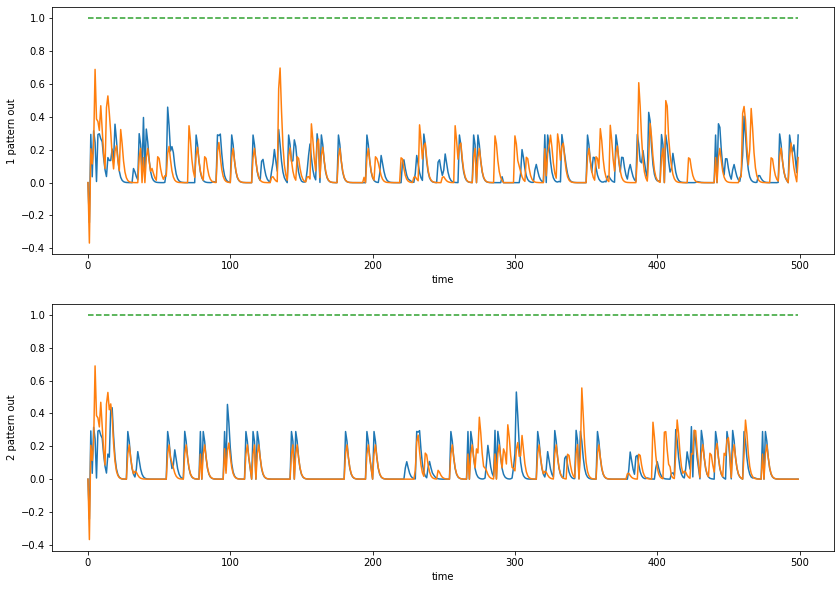

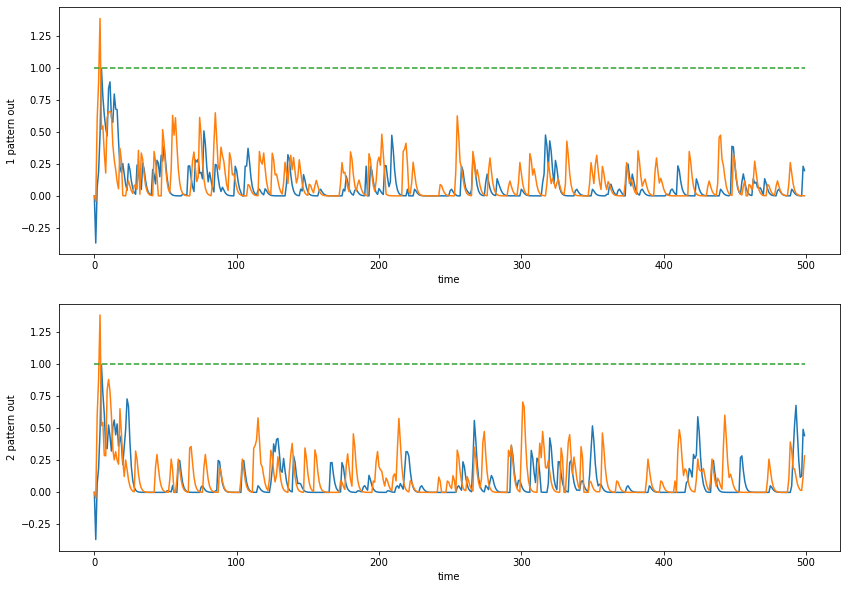

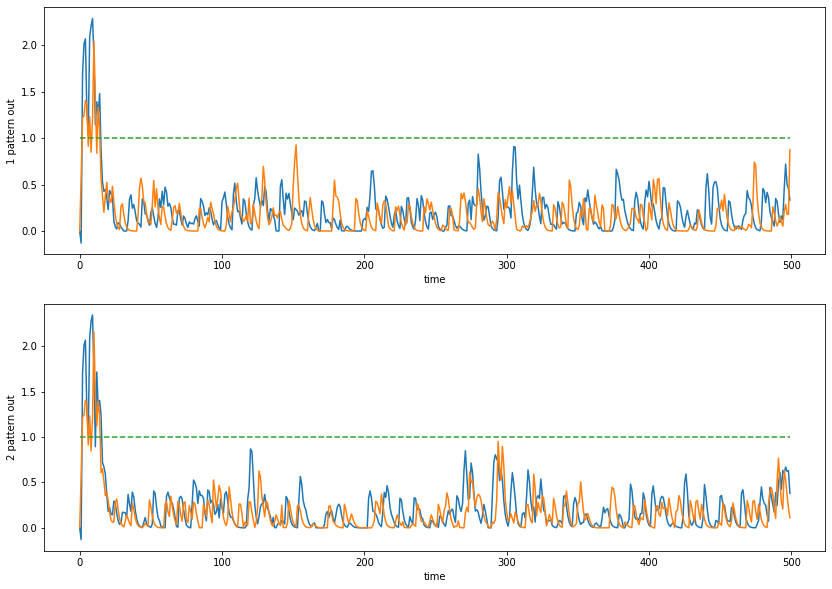

In [16]:
draw_plots(total_time, repeat_spike_pattern1, repeat_spike_pattern2)

In [17]:
def add_noise(pattern, p):
    noise = np.random.uniform(size=pattern.shape)
    random_signal = np.random.randint(2, size=pattern.shape)
    return np.where(noise < p, random_signal, pattern)

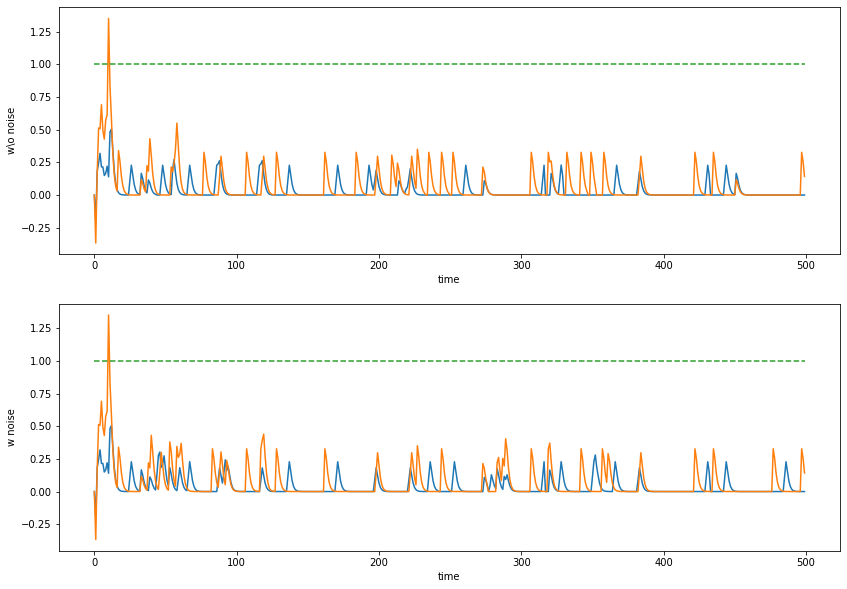

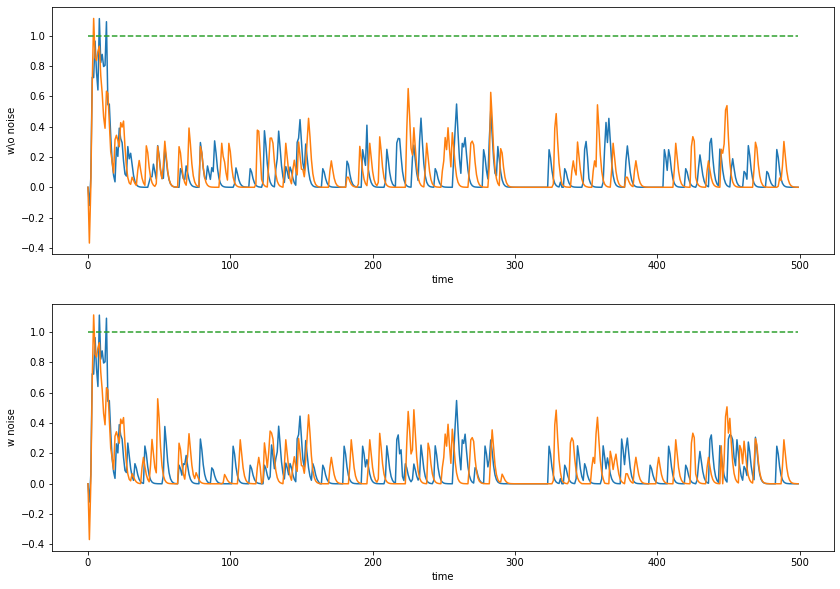

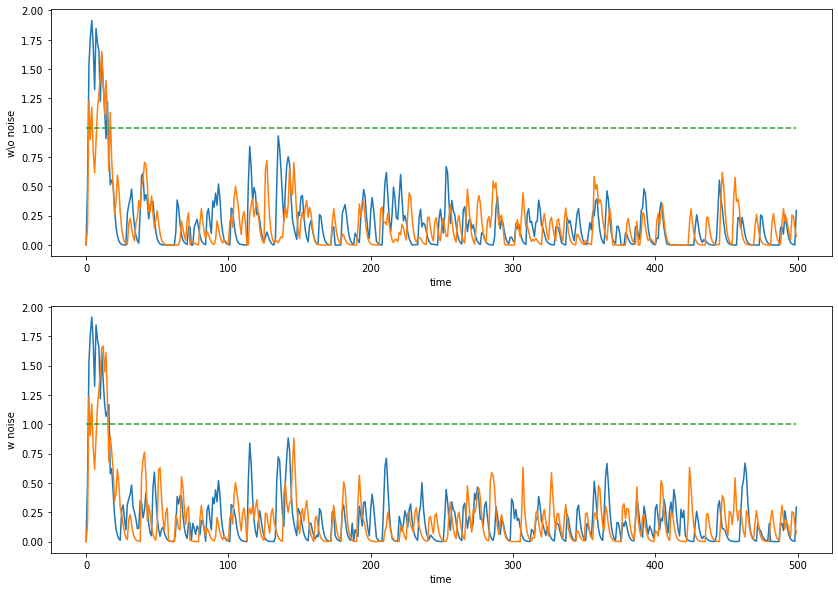

In [19]:
draw_plots(total_time, repeat_spike_pattern1, add_noise(repeat_spike_pattern1, 0.05), "w\o noise", "w noise")

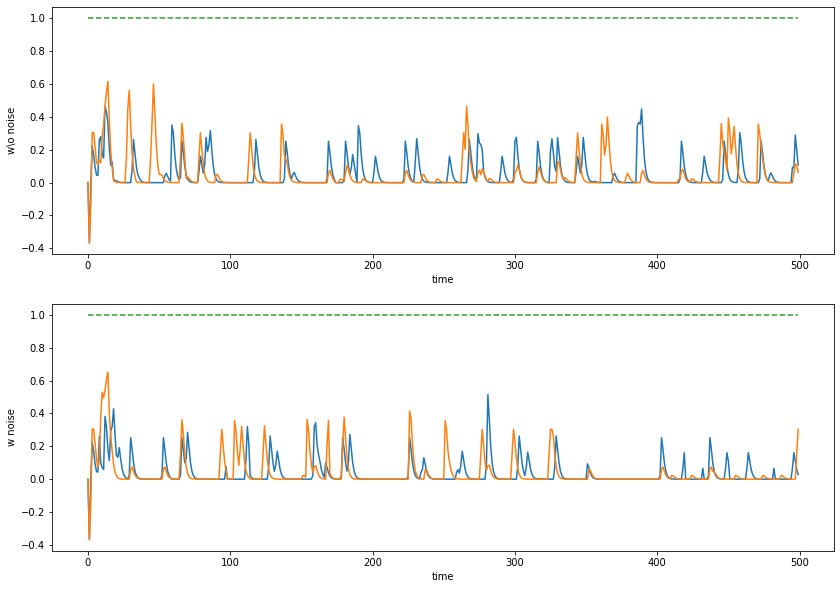

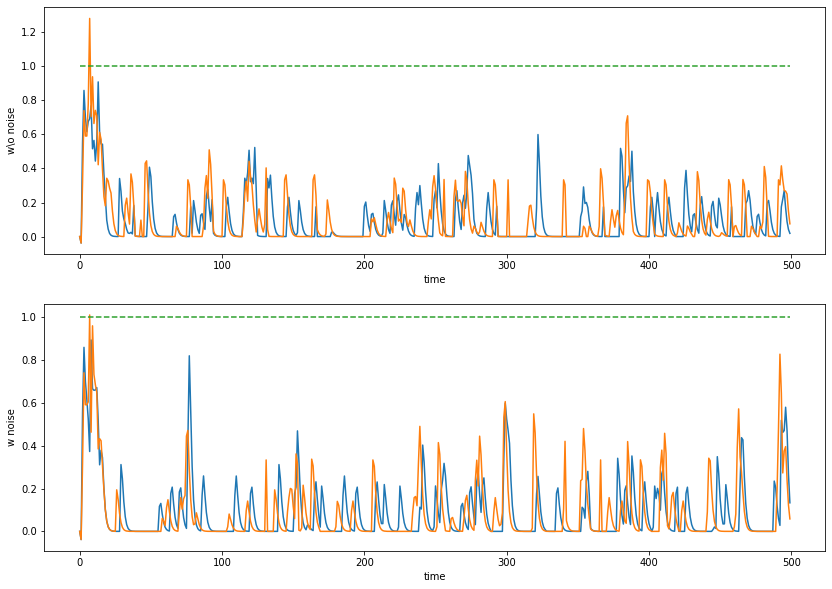

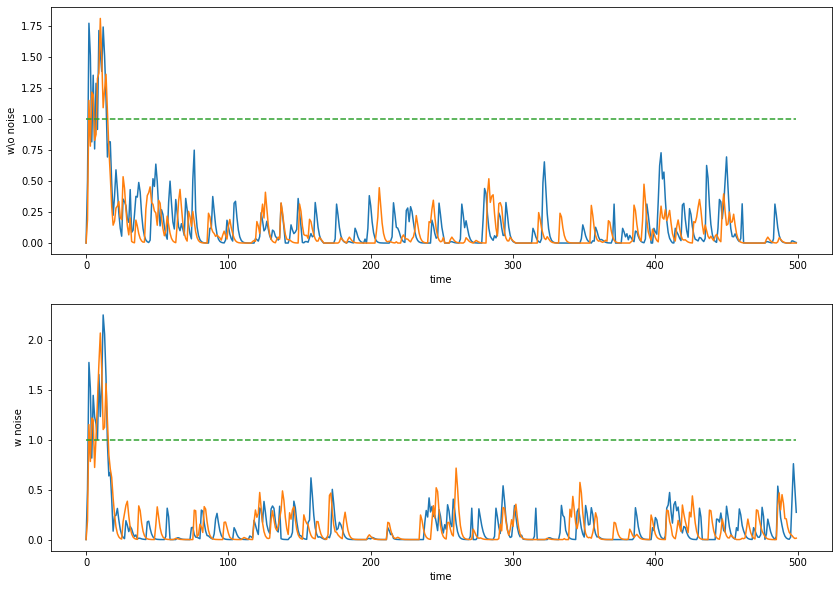

In [21]:
draw_plots(total_time, repeat_spike_pattern1, add_noise(repeat_spike_pattern2, 0.2), "w\o noise", "w noise")